## Full Model implementation and backtest

from my report this file produces the end-to-end process of:
- Sourcing historical data for two given oil contracts and creating a log spread for the two contracts
- Calibrating the above log-spread to the general OU process 
- Storing estimates for $\alpha$, $\mu$ & $\sigma$ to be used throughout the implementation
- Estimate transaction costs,$c$, for entering a trade in the specific spread 
- Determine optimal entry threshold, $a$ & $m$, using Bertram’s maximum expected return formula with $\alpha$,$\sigma$,$c$ (found previously) as inputs
- Adjust $a$ & $m$ by long run mean, $\mu$, to obtain $\hat{a}$ & $\hat{m}$ as above
- Run an out-of-sample backtest executing trades from $\hat{a}\rightarrow\ \hat{m}$ as well as the transition back from $\hat{m}\rightarrow\ \hat{a}$.

This process is repeated and tested on every posible contract combinationand output files are stored as such:

- parameter estimates: 'results_set_1.csv', 'results_set_2.csv', 'results_set_3.csv', 'results_set_4.csv' 

- backtest results: 'bt_results_1.csv', 'bt_results_2.csv', 'bt_results_3.csv', 'bt_results_4.csv'

Functions in this file have been validated in other files, please refer to:

- 'Validation1- Calibrating the OU.ipynb'
- 'Validation2- Mac Expected Return.ipynb'
- 'Validation3- Backtester.ipynb' 

for further resources, detailsand validation

### Import data and functions to be used 

In [108]:
import pandas as pd

# import dataset 
df = pd.read_csv('full_set.csv')
df = df.dropna()
#create list of all contractsin dataframe
cols = list(df.columns)
#remove date colums
cols = cols[1:]


# Generate list of all possible pairs
# Using list comprehension + enumerate() 
res = [(a, b) for idx, a in enumerate(cols) for b in cols[idx + 1:]] 


#FUNCTION
# calc_tc
# calculates transaction costs for a given spread to be used for maximising expected return
def calc_tc(spread):
    tcs = {'CO': 0.000289,
          'CL': 0.000940,
          'HO': 0.002482,
          'QS': 0.002482,
          'XB': 0.002482}
    return tcs[spread[0][0:2]] + tcs[spread[0][0:2]]

In [6]:
### function - implementaion of maximum expected return
### inputs:
### a - value for alpha
### n - value for eta
### c - transaction costs
### returns:
### res - rseult for a using eq. (18)


def mer(a,n,c):
    var1 = -c/4
    denom1 = (c**3*a**3) + (24*c*a**2*n**2)
    denom2 = 4*(np.sqrt(((3*c**4*a**5*n**2) + (36*c**2*a**4*n**4))))
    denom3 = 4 * ((denom1 - denom2)**(1/3))
    var2 = (c**2*a) / denom3
    numer1 = c**3*a**3 + (24*c*a**2*n**2)
    numer2 = 4 * np.sqrt((3*c**4*a**5*n**2 + 36*c**2*a**4*n**4))
    numer3 = ((numer1 - numer2))**(1/3)
    var3 = numer3 / (4*a)
    res = var1 - var2 - var3
    return res

In [51]:
import statsmodels.api as sm
import numpy as np
def OU_calibration(df, spread):
    dummy_df = pd.DataFrame()
    A = spread[0]
    B = spread[1]
    df['spread'] = np.log((df[B] / df[A]))
    df['shift'] = df.spread.shift()
    df.loc[0, 'shift'] = 0
    X = df['shift'].fillna(0)
    y = df['spread'].fillna(0)
    X = sm.add_constant(X)
    results = sm.OLS(y,X).fit()
    order = B, A
    
    if results.params[0] < 0:
        df['spread'] = np.log((df[A] / df[B]))
        df['shift'] = df.spread.shift()
        df.loc[0, 'shift'] = 0
        X = df['shift'].fillna(0)
        y = df['spread'].fillna(0)
        X = sm.add_constant(X)
        results = sm.OLS(y,X).fit()
        order = A, B
        
    
    a, b, sde= results.params[1], results.params[0], results.bse[1]
    
    alpha = -np.log(a) 
    mu = b/(1-a)
    sigma =sde*np.sqrt((-2*np.log(a))/(((1-a*a))))
    
    return alpha, mu,sigma, order


In [52]:
#create 4 test set dataframes for parameter estimation
split =int(len(df)/6)

test_set_1 =pd.DataFrame(df[0:split])

test_set_2 = pd.DataFrame(df[split:(split*2)])

test_set_3 = pd.DataFrame(df[(split*2):(split*3)])

test_set_4 = pd.DataFrame(df[(split*3):(split*4)])



### Parameter estimation
Now that data has been imported in, functions imported and datasets created for testingnow results sets are calibrated.
the below code will:

- Calibrating every spread to the general OU process 
- Store estimates for $\alpha$, $\mu$ & $\sigma$ 
- Estimate transaction costs,$c$, for entering a trade in the specific spread 
- Determine optimal entry threshold, $a$ & $m$, using Bertram’s maximum expected return formula with $\alpha$,$\sigma$,$c$ (found previously) as inputs

this is done across every spread and every test set create 1200 implementations for the model

In [53]:
results_set_1 =pd.DataFrame()
for i in range(0,len(res)):
    spread = res[i]
    alpha, mu,sigma, order = OU_calibration(test_set_1, spread)
    c= calc_tc(order) *0.5
    a = mer(alpha,sigma,c)
    #print (order, alpha, mu,sigma,c,a)
    results_set_1 = results_set_1.append(
            {  'spread': order, 
               'alpha': alpha,
               'mu':mu,
               'sigma':sigma,
               't_c': c,
               'a':a}, ignore_index=True)

results_set_2 =pd.DataFrame()
for i in range(0,len(res)):
    spread = res[i]
    alpha, mu,sigma, order = OU_calibration(test_set_2, spread)
    c= calc_tc(order)*0.5
    a = mer(alpha,sigma,c)
    #print (order, alpha, mu,sigma,c,a)
    results_set_2 = results_set_2.append(
            {  'spread': order, 
               'alpha': alpha,
               'mu':mu,
               'sigma':sigma,
               't_c': c,
               'a':a}, ignore_index=True)
    
results_set_3 =pd.DataFrame()
for i in range(0,len(res)):
    spread = res[i]
    alpha, mu,sigma, order = OU_calibration(test_set_3, spread)
    c= calc_tc(order)*0.5
    a = mer(alpha,sigma,c)
    #print (order, alpha, mu,sigma,c,a)
    results_set_3 = results_set_3.append(
            {  'spread': order, 
               'alpha': alpha,
               'mu':mu,
               'sigma':sigma,
               't_c': c,
               'a':a}, ignore_index=True)
    
results_set_4 =pd.DataFrame()
for i in range(0,len(res)):
    spread = res[i]
    alpha, mu,sigma, order = OU_calibration(test_set_4, spread)
    c= calc_tc(order)*0.5
    a = mer(alpha,sigma,c)
    #print (order, alpha, mu,sigma,c,a)
    results_set_4 = results_set_4.append(
            {  'spread': order, 
               'alpha': alpha,
               'mu':mu,
               'sigma':sigma,
               't_c': c,
               'a':a}, ignore_index=True)



### Backtesting 

In [91]:
# becktester function
#for further details read backtester validation

def backtester(a, mu, order, oil_data):
    bt_df = pd.DataFrame()
    bt_df['spread'] = np.log((oil_data[order[0]]/oil_data[order[1]]))
    bt_df['A_returns'] = np.log(oil_data[order[0]]/oil_data[order[0]].shift(1))
    bt_df['B_returns'] = np.log(oil_data[order[1]]/oil_data[order[1]].shift(1))
    
    entry = a + mu
    exit = -1*a + mu
    
    bt_df['Long_short'] = 0
    bt_df['Long_short'] = np.where(bt_df.spread < entry, 1, bt_df.Long_short)
    bt_df['Long_short'] = np.where(bt_df.spread > exit, -1, bt_df.Long_short)
    
    bt_df['Long_short_fill'] =  bt_df['Long_short'].replace(to_replace=0, method='ffill')
    

    bt_df['pnl'] = bt_df.Long_short_fill * bt_df.B_returns - bt_df.Long_short_fill * bt_df.A_returns
    
    total_return = bt_df.pnl.sum()
    
    sharpe = bt_df.pnl.mean() / bt_df.pnl.std() * np.sqrt(252)
    
    mean_return = bt_df.pnl.mean()
    
    trade_count = 0 
    for i in range(1,len(bt_df)):
        if bt_df.loc[i, 'Long_short_fill'] != bt_df.loc[i-1, 'Long_short_fill']:
            trade_count += 1
            
    if trade_count != 0:
        avg_hold_time = len(bt_df) / trade_count
    else:
        avg_hold_time = 0 
    return total_return, mean_return, sharpe, trade_count, avg_hold_time
    

In [92]:
#create 4 test set dataframes for parameter estimation
split =int(len(df)/6)

val_set_1 =pd.DataFrame(df[split:(split*3)])
val_set_1 = val_set_1.reset_index()

val_set_2 = pd.DataFrame(df[(split*2):(split*4)])
val_set_2 = val_set_2.reset_index()

val_set_3 = pd.DataFrame(df[(split*3):(split*5)])
val_set_3 = val_set_3.reset_index()

val_set_4 = pd.DataFrame(df[(split*4):])
val_set_4 = val_set_4.reset_index()



The below code completes the final process of the model running the full 1200 backtests storing each result in backtestoutput files

the below code will:
- Adjust $a$ & $m$ by long run mean, $\mu$, to obtain $\hat{a}$ & $\hat{m}$ as above
- Run an out-of-sample backtest executing trades from $\hat{a}\rightarrow\ \hat{m}$ as well as the transition back from $\hat{m}\rightarrow\ \hat{a}$.


In [93]:
bt_results_1 =pd.DataFrame()
for i in range(0,len(results_set_4)):
    total_return, mean_return, sharpe, trade_count, avg_hold_time = backtester(results_set_1.loc[i, 'a'], 
                                                                               results_set_1.loc[i, 'mu'], 
                                                                               results_set_1.loc[i, 'spread'], 
                                                                               val_set_1)
    
    #print (total_return, mean_return, sharpe, trade_count, avg_hold_time)
    bt_results_1 = bt_results_1.append(
            {  'spread': results_set_1.loc[i, 'spread'], 
               'total return': total_return,
               'mean return':mean_return,
               'sharpe':sharpe,
               'trade count': trade_count,
               'average hold time':avg_hold_time}, ignore_index=True)
    
bt_results_2 =pd.DataFrame()
for i in range(0,len(results_set_4)):
    total_return, mean_return, sharpe, trade_count, avg_hold_time = backtester(results_set_2.loc[i, 'a'], 
                                                                               results_set_2.loc[i, 'mu'], 
                                                                               results_set_2.loc[i, 'spread'], 
                                                                               val_set_2)
    
    #print (total_return, mean_return, sharpe, trade_count, avg_hold_time)
    bt_results_2 = bt_results_2.append(
            {  'spread': results_set_2.loc[i, 'spread'], 
               'total return': total_return,
               'mean return':mean_return,
               'sharpe':sharpe,
               'trade count': trade_count,
               'average hold time':avg_hold_time}, ignore_index=True)
    
bt_results_3 =pd.DataFrame()
for i in range(0,len(results_set_4)):
    total_return, mean_return, sharpe, trade_count, avg_hold_time = backtester(results_set_3.loc[i, 'a'], 
                                                                               results_set_3.loc[i, 'mu'], 
                                                                               results_set_3.loc[i, 'spread'], 
                                                                               val_set_3)
    
    #print (total_return, mean_return, sharpe, trade_count, avg_hold_time)
    bt_results_3 = bt_results_3.append(
            {  'spread': results_set_3.loc[i, 'spread'], 
               'total return': total_return,
               'mean return':mean_return,
               'sharpe':sharpe,
               'trade count': trade_count,
               'average hold time':avg_hold_time}, ignore_index=True)
    
bt_results_4 =pd.DataFrame()
for i in range(0,len(results_set_4)):
    total_return, mean_return, sharpe, trade_count, avg_hold_time = backtester(results_set_4.loc[i, 'a'], 
                                                                               results_set_4.loc[i, 'mu'], 
                                                                               results_set_4.loc[i, 'spread'], 
                                                                               val_set_4)
    
    #print (total_return, mean_return, sharpe, trade_count, avg_hold_time)
    bt_results_4 = bt_results_4.append(
            {  'spread': results_set_4.loc[i, 'spread'], 
               'total return': total_return,
               'mean return':mean_return,
               'sharpe':sharpe,
               'trade count': trade_count,
               'average hold time':avg_hold_time}, ignore_index=True)
    


c:\users\mat\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
c:\users\mat\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\mat\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
c:\users\mat\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


### Store results
### Data Visualisations
### Performance evaluation

This code createsresources that willbe referenced and discussed more in the written report 

In [96]:
results_set_1.to_csv('results_set_1.csv')
results_set_2.to_csv('results_set_2.csv')
results_set_3.to_csv('results_set_3.csv')
results_set_4.to_csv('results_set_4.csv')

bt_results_1.to_csv('bt_results_1.csv')
bt_results_2.to_csv('bt_results_2.csv')
bt_results_3.to_csv('bt_results_3.csv')
bt_results_4.to_csv('bt_results_4.csv')

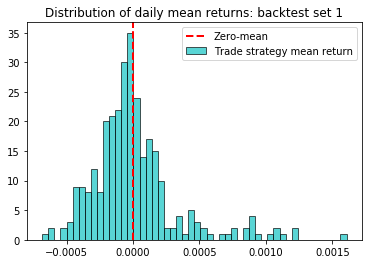

In [95]:
import matplotlib.pyplot as plt 

plt.hist(bt_results_1['mean return'], bins=50, color='c', edgecolor='k', alpha=0.65)
plt.axvline(-0, color='red', linestyle = 'dashed', linewidth =2)
plt.title('Distribution of daily mean returns: backtest set 1')
plt.legend(['Zero-mean', 'Trade strategy mean return'])
plt.show()

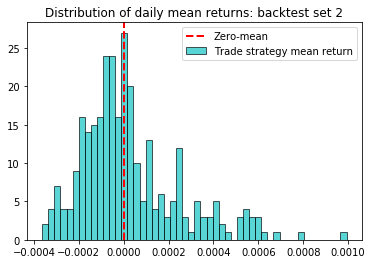

In [97]:
plt.hist(bt_results_2['mean return'], bins=50, color='c', edgecolor='k', alpha=0.65)
plt.axvline(-0, color='red', linestyle = 'dashed', linewidth =2)
plt.title('Distribution of daily mean returns: backtest set 2')
plt.legend(['Zero-mean', 'Trade strategy mean return'])
plt.show()

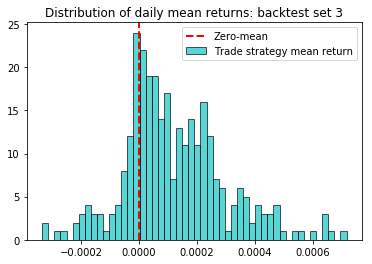

In [98]:
plt.hist(bt_results_3['mean return'], bins=50, color='c', edgecolor='k', alpha=0.65)
plt.axvline(-0, color='red', linestyle = 'dashed', linewidth =2)
plt.title('Distribution of daily mean returns: backtest set 3')
plt.legend(['Zero-mean', 'Trade strategy mean return'])
plt.show()

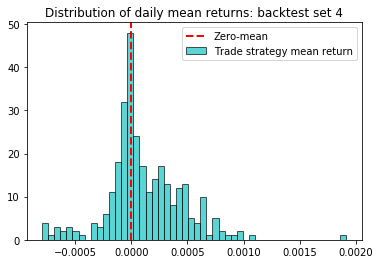

In [99]:
plt.hist(bt_results_4['mean return'], bins=50, color='c', edgecolor='k', alpha=0.65)
plt.axvline(-0, color='red', linestyle = 'dashed', linewidth =2)
plt.title('Distribution of daily mean returns: backtest set 4')
plt.legend(['Zero-mean', 'Trade strategy mean return'])
plt.show()

In [107]:
print (len(bt_results_1.loc[bt_results_1['mean return'] >0 ]))
print (bt_results_1['mean return'].mean())
print (bt_results_1['sharpe'].mean())
print (bt_results_1['total return'].mean())
print (bt_results_1['trade count'].mean())
print (bt_results_1['average hold time'].mean())
print (bt_results_1['sharpe'].max())

119
5.074679998352573e-06
-0.05567647461305129
0.003049882679009889
6.456666666666667
146.3881350986599
1.3893374070165883


In [106]:
print (len(bt_results_2.loc[bt_results_2['mean return'] >0 ]))
print (bt_results_2['mean return'].mean())
print (bt_results_2['sharpe'].mean())
print (bt_results_2['total return'].mean())
print (bt_results_2['trade count'].mean())
print (bt_results_2['average hold time'].mean())
print (bt_results_2['sharpe'].max())

136
2.554916668913911e-05
-0.0019030193254647512
0.015355049180172603
3.546666666666667
234.3005516705517
1.211319363147012


In [105]:
print (len(bt_results_3.loc[bt_results_3['mean return'] >0 ]))
print (bt_results_3['mean return'].mean())
print (bt_results_3['sharpe'].mean())
print (bt_results_3['total return'].mean())
print (bt_results_3['trade count'].mean())
print (bt_results_3['average hold time'].mean())
print (bt_results_3['sharpe'].max())

231
0.00012200366581670459
0.18201815220494555
0.07332420315583946
3.0166666666666666
194.40897860962565
0.8119717757798565


In [103]:
print (len(bt_results_4.loc[bt_results_4['mean return'] >0 ]))
print (bt_results_4['mean return'].mean())
print (bt_results_4['sharpe'].mean())
print (bt_results_4['sharpe'].max())
print (bt_results_4['total return'].mean())
print (bt_results_4['trade count'].mean())
print (bt_results_4['average hold time'].mean())

175
0.00011393680603696679
0.07613989038106037
1.0582007238542632
0.06910536585608021
6.793333333333333
139.42429360944067
